# DATA620: Project 3 - Gender Identification

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

<br>
We chose to use the NaiveBayesClassifier machine learning method to categorize the names Corpus. 

### Load Required Packages

In [1]:
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.probability import FreqDist
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from sklearn.model_selection import KFold
from statistics import mean


<br>

### Model Base Class
This is a Generic class with base model and boiler plate analysis code. It is used to simplify the analysis for each subsequent model.

In [2]:

# generic class with base model
class GenderAnalysis():
    
    # set corpus and training datasets
    def __init__(self):
       
        random.seed(3210)
        self._classifier = None
        
        # Import and Lable Names
        self._names_lst = ([(name, 'male') for name in names.words('male.txt')] +
                [(name, 'female') for name in names.words('female.txt')])
        random.shuffle(self._names_lst)

        # Split Corpus
        self._train_names = self._names_lst[1000:]
        self._devtest_names = self._names_lst[500:1000]
        self._test_names = self._names_lst[:500]
    
        # apply features training, devtest and test corpus
        self._train_set = apply_features(self.gender_features, self._train_names)
        self._devtest_set = apply_features(self.gender_features, self._devtest_names)
        self._test_set = apply_features(self.gender_features, self._test_names)          

 
    # generate features
    def gender_features(self, name):
        pass
    
    
    # get features dataframe 
    def get_names_features(self):
        # analyze data
        df = pd.DataFrame(self._names_lst, columns=['name','gender'])
        return df
    
    
    # get names that can be both male and female
    def ambiguous_names(self):
        # analyze data
        df = pd.DataFrame(self._names_lst, columns=['name','gender'])
        df2 = df.groupby(['name'])['name'].count().reset_index(name='count').sort_values(
            ['count'], ascending=False)
        df2 = df2[df2['count']>1]
        name_df = pd.merge(df,df2,how="inner", on=["name"])
        
        #name_df = name_df.drop('count', 1)
        name_df = name_df[['name']]
        name_df = name_df.groupby('name').first().reset_index()
        
        return name_df
    
    
    # train the model
    def train(self):
        self._classifier = nltk.NaiveBayesClassifier.train(self._train_set)
        
        
    # return the accuracy of the dev test
    def get_devtest_accuracy(self):     
        return nltk.classify.accuracy(self._classifier, self._devtest_set)
        

    # return the features with the biggest impact
    def show_inform_feature(self, n=20):
        self._classifier.show_most_informative_features(n)
        
    
    # return a dataframe with the errors
    def get_errors(self):
        errors = []
        for (name, tag) in self._devtest_names:
            guess = self._classifier.classify(self.gender_features(name))
            if guess != tag:
                errors.append((tag, guess, name))                
          
        errors_df = pd.DataFrame(errors, columns=['tag', 'guess', 'name'])
        return errors_df
    
    
    # print the model errors
    def print_Errors(self):
        for (tag, guess, name) in sorted(errors):
            print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

     
    # print the errors that are driven by Unisex names
    def get_ambiguous_errors(self):
        df1 = self.ambiguous_names()
        df2 = self.get_errors()
        error_df = pd.merge(df1,df2,how="inner", on=["name"])
        return error_df
    
    
    # determint the accuracy of the model using test data
    def get_test_accuracy(self):
        return nltk.classify.accuracy(self._classifier, self._test_set)
    
    # explore of error records
    def get_error_stats(self):
              
        df = self.get_errors()
        
        df['length'] = df['name'].str.len()
        df['last_letter'] = df['name'].str[-1]
        df['first_letter'] = df['name'].str[0]

        df['vowels'] = df['name'].str.replace(r'[^aeiou]', '', regex=True)
        df['vowel_last_letter'] = df['last_letter'].isin([*'aeiouy'])
        df['vowel_first_letter'] = df['first_letter'].isin([*'AEIOUY'])

        df['consonants'] = df['name'].str.replace(r'[aeiou]', '', regex=True)
        df['consonant_last_letter'] = df['last_letter'].isin([*'qwrtplkjhgfdszxcvbnm'])
        df['consonant_first_letter'] = df['first_letter'].isin([*'QWRTPLKJHGFDSZXCVBNM'])

        df['num_vowels'] = df['vowels'].str.len()
        df['num_consonants'] = df['consonants'].str.len()
        
        return df
    

<br>

### K-Fold Sub Class
The K-Fold sub class adds a method to the generic class that genereates test stats for the k-fold validation

In [3]:
# generic class with base model
class GenderAnalysisKFold(GenderAnalysis):

       
    # get kfold
    def get_kfold(self, n=10):
        
        cross_val_names = self._names_lst[500:]

        kf = KFold(n_splits=n)
        variables = apply_features(self.gender_features, cross_val_names)
        
        
        test_accuracy = {}
        sum = 0
        i = 1
        for train, test in kf.split(variables):
            train_data = np.array(variables)[train]
            test_data = np.array(variables)[test]
            classifier = nltk.NaiveBayesClassifier.train(train_data)
            test_accuracy.update({'k_'+str(i):round(nltk.classify.accuracy(classifier, test_data),3)})           
            i += 1
        
        test_accuracy.update({'k_average':round(mean(test_accuracy.values()),3)})        
        return pd.DataFrame([test_accuracy])

<br>

### Model Sub-classes
Each Model class inherits from the GenderAnalusis base class. The key difference between each subclass is the implimention of the gender_features().

In [4]:

# Uses the last letters as features 
class GenderAnalysis1(GenderAnalysisKFold):
    
    def gender_features(self, name):
        features = {}
        features["suffix1"] = name[-1].lower()
        return features



# Uses the last 2 letters as features 
class GenderAnalysis2(GenderAnalysisKFold):
    
    def gender_features(self, name):
        features = {}
        features["suffix1"] = name[-1].lower()
        features["suffixLast2"] = name[-2:].lower()

        return features

    
# Use the last 2 letter and the first letter as features
class GenderAnalysis3(GenderAnalysisKFold):
    
    def gender_features(self, name):
        features = {}
        features["firstLetter"] = name[0].lower()
        features["suffix1"] = name[-1].lower()
        features["suffixLast2"] = name[-2:].lower()

        return features
    

# Add the vowels as first and last charater and vowel count 
class GenderAnalysis4(GenderAnalysisKFold):
    
    
    def gender_features(self, name):
        features = {}
        features["length"] = len(name)
        features["firstLetter"] = name[0].lower()
        features["lastLetter"] = name[-1].lower()
        features["firstVowel"] = features['firstLetter'] in 'aeiouy'
        features["lastVowel"] = features['lastLetter'] in 'aeiouy'

        # Gets num of vowels
        count = 0
        vowel = set("aeiouAEIOU")

        for i in name:
            if i in vowel:
                count = count + 1

        features["numVowels"] = count
        features["suffixLast2"] = name[-2:].lower()
        features["suffixLast3"] = name[-3:].lower()

        return features

<br>

### Analysis of Names Corpus
The corpus includes 365 Unisex names that have both male and female records. 

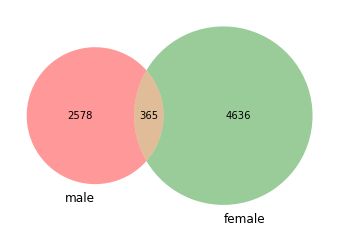

In [5]:
ga1 = GenderAnalysis1()
ga1.train()

# Use the venn2 function
df = ga1.get_names_features()
s1 = set(df[df['gender'] == 'male']['name'])
s2 = set(df[df['gender'] == 'female']['name'])
venn2([s1, s2], set_labels = ('male', 'female'))
plt.show()

This Venn diagram captures that overlap of unisex names between the male and female populations. Interestingly enough there are many more female names in the corpus than male names. 

<br>

### Further Exploration of Names Corpus


In [6]:
# explore data further
df['length'] = df['name'].str.len()
df['last_letter'] = df['name'].str[-1]
df['first_letter'] = df['name'].str[0]

df['vowels'] = df['name'].str.replace(r'[^aeiouyAEIOUY]', '', regex=True)
df['vowel_last_letter'] = df['last_letter'].isin([*'aeiouy'])
df['vowel_first_letter'] = df['first_letter'].isin([*'AEIOUY'])

df['consonants'] = df['name'].str.replace(r'[aeiouyAEIOUY]', '', regex=True)
df['consonant_last_letter'] = df['last_letter'].isin([*'qwrtplkjhgfdszxcvbnm'])
df['consonant_first_letter'] = df['first_letter'].isin([*'QWRTPLKJHGFDSZXCVBNM'])

df['num_vowels'] = df['vowels'].str.len()
df['num_consonants'] = df['consonants'].str.len()

df.head()

,name,gender,length,last_letter,first_letter,vowels,vowel_last_letter,vowel_first_letter,consonants,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
0,Merissa,female,7,a,M,eia,True,False,Mrss,False,True,3,4
1,Audy,female,4,y,A,Auy,True,True,d,False,False,3,1
2,Rene,female,4,e,R,ee,True,False,Rn,False,True,2,2
3,Elnore,female,6,e,E,Eoe,True,True,lnr,False,False,3,3
4,Cletus,male,6,s,C,eu,False,False,Clts,True,True,2,4


In [7]:
df.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
gender,,,,,,,
female,6.113777,0.804239,0.174965,0.195561,0.825035,2.835033,3.278744
male,5.895345,0.358818,0.158682,0.641182,0.841318,2.359497,3.535848


Notable differences between groups in the corpus:
* Female names tend to be longer
* Female names are much more likely to contain a vowel as the last letter
* Female names are slightly more likely to have a vowel as a first letter
* Males are much more likely to have a consonant for a last letter
* Both groups are almost equally likely to have a consonant as a first letter
* Females have more vowels on average
* Males have more consonants on average

This information provides us with a strong baseline for features to use in our gender name classifier.

In [8]:
print('Size Train Set',len(ga1._train_names))
print('Size Development Set',len(ga1._devtest_names))
print('Size Test Set',len(ga1._test_names))



Size Train Set 6944
Size Development Set 500
Size Test Set 500


<br>

### Model 1
This is a simple model the looks at the last character of a name to determine the associated gender. This model has a 80% accuracy if we use 3210 as the seed. We can also count the number of errors that are driven by unisex names. With Model 1 there are 27 errors that can be attributed to unisex names.

In [9]:
ga1 = GenderAnalysis1()
ga1.train()
print('devtest accuracy:', ga1.get_devtest_accuracy())
print('ambiguous errors:',len(ga1.get_ambiguous_errors()))

devtest accuracy: 0.8
ambiguous errors: 27


<br>

The feature list below identifies the features that have the biggest impact on the model. 

In [10]:
ga1.show_inform_feature(10)

Most Informative Features
                 suffix1 = 'a'            female : male   =     35.6 : 1.0
                 suffix1 = 'k'              male : female =     30.3 : 1.0
                 suffix1 = 'f'              male : female =     15.5 : 1.0
                 suffix1 = 'v'              male : female =     11.4 : 1.0
                 suffix1 = 'w'              male : female =     11.4 : 1.0
                 suffix1 = 'p'              male : female =     10.7 : 1.0
                 suffix1 = 'd'              male : female =      9.8 : 1.0
                 suffix1 = 'm'              male : female =      9.4 : 1.0
                 suffix1 = 'o'              male : female =      8.2 : 1.0
                 suffix1 = 'r'              male : female =      6.5 : 1.0


<br>

The table below summarizes the default model performance for each last letter. The accuracy levels and the resulting number of errors are high for:
* n - all names that end with n are classified as male
* e - all names that end in e are classified female
* y - all names that end in y are classified female

In [11]:
# calculate the number of names in devtest that end with each letter
n_df = pd.DataFrame(ga1._devtest_names, columns=['name','gender'])
n_df['last_letter'] = n_df['name'].str[-1]
n_df = n_df.groupby(['last_letter'])['last_letter'].count().reset_index(name='count').sort_values(['count'], ascending=False)

# calculate the errors
e_df = ga1.get_errors()
e_df['last_letter'] = e_df['name'].str[-1]
e_df = e_df.groupby(['last_letter'])['last_letter'].count().reset_index(name='error_count')

# merge the dataframes
n_df = pd.merge(n_df,e_df,how="inner", on=["last_letter"])
n_df['accuracy'] = round(1 - n_df['error_count'] / n_df['count'],3)

# calculate the model accuracy for each letter
n_df.sort_values(['error_count'], ascending=False)

,last_letter,count,error_count,accuracy
1,n,62,29,0.532
0,e,115,21,0.817
3,l,27,17,0.370
2,y,40,16,0.600
10,h,8,4,0.500
6,s,23,3,0.870
4,i,26,2,0.923
5,d,23,2,0.913
9,m,9,2,0.778
7,r,17,1,0.941


 <br>

### Model 2

This model extends the simple model and uses the last letter and the last 2 letters as features for name categorization. This model has a 82.8% accuracy if we use 3210 as the seed. We can also count the number of errors that are driven by unisex names. With Model 2 there are 21 errors that can be attributed to unisex names.

In [12]:
ga2 = GenderAnalysis2()
ga2.train()
print('devtest accuracy:', ga2.get_devtest_accuracy())
print('ambiguous errors:',len(ga2.get_ambiguous_errors()))

devtest accuracy: 0.828
ambiguous errors: 21


<br>

The feature list below identifies the features that have the biggest impact on the model. It should be noted that suffixLast2 features dominate the top features list. Indicating that using 2 of the last characters is more deterministic of gender. 

In [13]:
ga2.show_inform_feature(10)

Most Informative Features
             suffixLast2 = 'na'           female : male   =     91.2 : 1.0
             suffixLast2 = 'la'           female : male   =     69.6 : 1.0
             suffixLast2 = 'ia'           female : male   =     36.9 : 1.0
                 suffix1 = 'a'            female : male   =     35.6 : 1.0
             suffixLast2 = 'ra'           female : male   =     33.2 : 1.0
             suffixLast2 = 'sa'           female : male   =     30.9 : 1.0
                 suffix1 = 'k'              male : female =     30.3 : 1.0
             suffixLast2 = 'us'             male : female =     26.3 : 1.0
             suffixLast2 = 'do'             male : female =     24.2 : 1.0
             suffixLast2 = 'ta'           female : male   =     24.1 : 1.0


<br>

The errors in name gender categorization are summarized in the following data frame. It is difficult to identify patterns at the individual name level so we will run some sample stats

In [14]:
e_df = ga2.get_errors()
e_df.head()

,tag,guess,name
0,male,female,Abdullah
1,female,male,Cam
2,male,female,Kelly
3,female,male,Shaun
4,female,male,Jaclin


<br>

The error data still shows some discrepancy in the vowel as last letter and the constant as last letter.

In [15]:
e_df = ga2.get_error_stats()
e_df.groupby('tag').mean()

,length,vowel_last_letter,vowel_first_letter,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
tag,,,,,,,
female,5.734694,0.183673,0.183673,0.816327,0.816327,1.959184,3.775510
male,5.621622,0.783784,0.216216,0.216216,0.783784,2.054054,3.567568


<br>

### Model 3
This model extends the simple model and uses first letter, the last letter, the last 2 letters as features for name categorization.  This model has a 84.4% accuracy if we use 3210 as the seed. We can also count the number of errors that are driven by unisex names. With Model 3 there are 24 errors that can be attributed to unisex names.


In [16]:
ga3 = GenderAnalysis3()
ga3.train()

print('devtest accuracy:', ga3.get_devtest_accuracy())
print('ambiguous errors:',len(ga3.get_ambiguous_errors()))

devtest accuracy: 0.844
ambiguous errors: 24


<br>

The feature list below identifies the features that have the biggest impact on the model. It should be noted that suffixLast2 features dominate the top features list and the first letter does not appear as a top 20 feature . Indicating that using 2 of the last characters is more deterministic of gender.

In [17]:
ga3.show_inform_feature(10)

Most Informative Features
             suffixLast2 = 'na'           female : male   =     91.2 : 1.0
             suffixLast2 = 'la'           female : male   =     69.6 : 1.0
             suffixLast2 = 'ia'           female : male   =     36.9 : 1.0
                 suffix1 = 'a'            female : male   =     35.6 : 1.0
             suffixLast2 = 'ra'           female : male   =     33.2 : 1.0
             suffixLast2 = 'sa'           female : male   =     30.9 : 1.0
                 suffix1 = 'k'              male : female =     30.3 : 1.0
             suffixLast2 = 'us'             male : female =     26.3 : 1.0
             suffixLast2 = 'do'             male : female =     24.2 : 1.0
             suffixLast2 = 'ta'           female : male   =     24.1 : 1.0


<br>

The errors in name gender categorization are summarized in the following data frame. It is difficult to identify patterns at the individual name level so we will run some sample stats

In [18]:
e_df = ga3.get_errors()
e_df.head()

,tag,guess,name
0,male,female,Abdullah
1,female,male,Cam
2,male,female,Kelly
3,female,male,Shaun
4,female,male,Jaclin


The error data analysis still shows two discrepancy in the vowel as last letter and the constant as last letter gender breakdown. 

In [19]:
e_df = ga3.get_error_stats()
e_df.groupby('tag').mean()

,length,vowel_last_letter,vowel_first_letter,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
tag,,,,,,,
female,5.514286,0.057143,0.200000,0.942857,0.800000,1.971429,3.542857
male,5.511628,0.744186,0.255814,0.255814,0.744186,1.906977,3.604651


<br>

### Model 4

This model extends the simple model and uses first letter, the last letter, the last 2 letters as features for name categorization. It also uses the length of the name and the vowel counts as features for the name. This model has a 84.2% accuracy if we use 3210 as the seed. We can also count the number of errors that are driven by unisex names. With Model 4 there are 22 errors that can be attributed to unisex names.

In [20]:
ga4 = GenderAnalysis4()
ga4.train()


print('devtest accuracy:', ga4.get_devtest_accuracy())
print('ambiguous errors:',len(ga4.get_ambiguous_errors()))


devtest accuracy: 0.842
ambiguous errors: 22


<br>

The feature list below identifies the features that have the biggest impact on the model. It should be noted that suffixLast2 features dominate the top features list and the first letter or the vowel related features do not appear as a top 20 feature.

In [21]:
ga4.show_inform_feature(10)

Most Informative Features
             suffixLast2 = 'na'           female : male   =     91.2 : 1.0
             suffixLast2 = 'la'           female : male   =     69.6 : 1.0
             suffixLast2 = 'ia'           female : male   =     36.9 : 1.0
              lastLetter = 'a'            female : male   =     35.6 : 1.0
             suffixLast2 = 'ra'           female : male   =     33.2 : 1.0
             suffixLast2 = 'sa'           female : male   =     30.9 : 1.0
              lastLetter = 'k'              male : female =     30.3 : 1.0
             suffixLast2 = 'us'             male : female =     26.3 : 1.0
             suffixLast3 = 'ana'          female : male   =     24.3 : 1.0
             suffixLast3 = 'tta'          female : male   =     24.3 : 1.0


The errors in name gender categorization are summarized in the following data frame. It is difficult to identify patterns at the individual name level so we will run some sample stats

In [22]:
e_df = ga4.get_errors()
e_df.head()

,tag,guess,name
0,male,female,Abdullah
1,female,male,Cam
2,male,female,Kelly
3,female,male,Adah
4,female,male,Shaun


The error data analysis still shows two discrepancy in the vowel as last letter and the constant as last letter gender breakdown.

In [23]:
e_df = ga3.get_error_stats()
e_df.groupby('tag').mean()

,length,vowel_last_letter,vowel_first_letter,consonant_last_letter,consonant_first_letter,num_vowels,num_consonants
tag,,,,,,,
female,5.514286,0.057143,0.200000,0.942857,0.800000,1.971429,3.542857
male,5.511628,0.744186,0.255814,0.255814,0.744186,1.906977,3.604651


<br>

### Model Accuracy
The accuracy for name categorization estimates seems to platau at roughly 85%. There appears to be some room to improve based on the treatment of vowels and consonants as the last letter. 

In [24]:
result_lst = []
result_lst.append(['ga1',ga1.get_devtest_accuracy(),len(ga1.get_errors()),len(ga1.get_ambiguous_errors()),ga1.get_test_accuracy()])
result_lst.append(['ga2',ga2.get_devtest_accuracy(),len(ga2.get_errors()),len(ga2.get_ambiguous_errors()),ga2.get_test_accuracy()])
result_lst.append(['ga3',ga3.get_devtest_accuracy(),len(ga3.get_errors()),len(ga3.get_ambiguous_errors()),ga3.get_test_accuracy()])
result_lst.append(['ga4',ga4.get_devtest_accuracy(),len(ga4.get_errors()),len(ga4.get_ambiguous_errors()),ga4.get_test_accuracy()])

#result_df = pd.DataFrame(result_lst)
result_df = pd.DataFrame(result_lst, columns=['id','dt_accuracy','errors','ambiguous_errors','test_accuracy'])
result_df

,id,dt_accuracy,errors,ambiguous_errors,test_accuracy
0,ga1,0.800,100,27,0.754
1,ga2,0.828,86,21,0.790
2,ga3,0.844,78,24,0.794
3,ga4,0.842,79,22,0.810


<br>

### K-Fold Cross Validation
Using the K-fold method for cross validation we can examine how widely the performance varies across different training sets. K-fold cross validation will help us Identify the most "stable" model on out of sample data.

- First k fold produced the highest accuracy for each model
- Sixth k fold produced the lowest accuracy for each model
- Most of Model 1's results are within 1.5% of mean accuracy with the largest being 2.4%
- Most of Model 2's results are within 2% of mean accuracy with the largest being 3.7%
- Most of Model 3's results are within 2% of mean accuracy with the largest being 4.3%
- Most of Model 4's results are within 1.25% of mean accuracy with the largest being 3.7%

In [25]:
# list
lst = []

# model 1
dict = ga1.get_kfold().to_dict(orient='index')[0]
dict.update({'id':'ga1'})
lst.append(dict)

# model 2
dict = ga2.get_kfold().to_dict(orient='index')[0]
dict.update({'id':'ga2'})
lst.append(dict)

# model 3
dict = ga3.get_kfold().to_dict(orient='index')[0]
dict.update({'id':'ga3'})
lst.append(dict)

# model 4
dict = ga4.get_kfold().to_dict(orient='index')[0]
dict.update({'id':'ga4'})
lst.append(dict)

# k folds dataframe
df = pd.DataFrame(lst)

In [26]:
# summary data
pd.merge(left=result_df,right=df,left_on='id',right_on='id')

,id,dt_accuracy,errors,ambiguous_errors,test_accuracy,k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,k_average
0,ga1,0.800,100,27,0.754,0.787,0.760,0.757,0.752,0.758,0.751,0.770,0.757,0.762,0.767,0.762
1,ga2,0.828,86,21,0.790,0.816,0.774,0.766,0.770,0.766,0.755,0.785,0.782,0.790,0.780,0.778
2,ga3,0.844,78,24,0.794,0.834,0.791,0.781,0.776,0.778,0.767,0.794,0.788,0.793,0.801,0.790
3,ga4,0.842,79,22,0.810,0.831,0.781,0.787,0.780,0.781,0.774,0.804,0.797,0.797,0.806,0.794


From the analysis we can see that Model 3 and Model 4 both perform well on all accuracy metrics, compared to the other models. Model 4 appears to be the better of the two models on out of sample performance, as it has the highest testing data accuracy and best average k-fold cross validation accuracy. Model 4 also had a fairly consistent accuracy across all k fold training sets, indicating that we can be fairly confident that the score is accurate. However it should be noted that this number can fluctuate depending on the ramdom seed selected.


<br>

### Conclusion
The difficulties associated with getting better accuracy in the gender classification names is impacted by the prevalence of unisex names. With 365 unisex names in the corpus it is common to see 24% to 28% of the errors are generated by unisex names that appear in corpus as both male and female names. 